In [52]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms

from torchinfo import summary
import data_setup
from engine import *
from helper_functions import plot_loss_curves


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [31]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

In [32]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [33]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [34]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

In [35]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [36]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [37]:
from torchinfo import summary

summary(model=model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [38]:
for param in model.features.parameters():
    param.requires_grad = False

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

In [40]:
summary(model=model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, 
                loss_fn=loss_fn, epochs=5, device=device)

end_time = timer()
print("Training time: {} seconds".format(end_time - start_time))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0901 | train_acc: 0.4102 | test_loss: 0.8925 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.9162 | train_acc: 0.6367 | test_loss: 0.8032 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.8170 | train_acc: 0.7070 | test_loss: 0.6780 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7456 | train_acc: 0.7266 | test_loss: 0.6718 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6219 | train_acc: 0.7656 | test_loss: 0.6246 | test_acc: 0.8561
Training time: 174.28339945799962 seconds


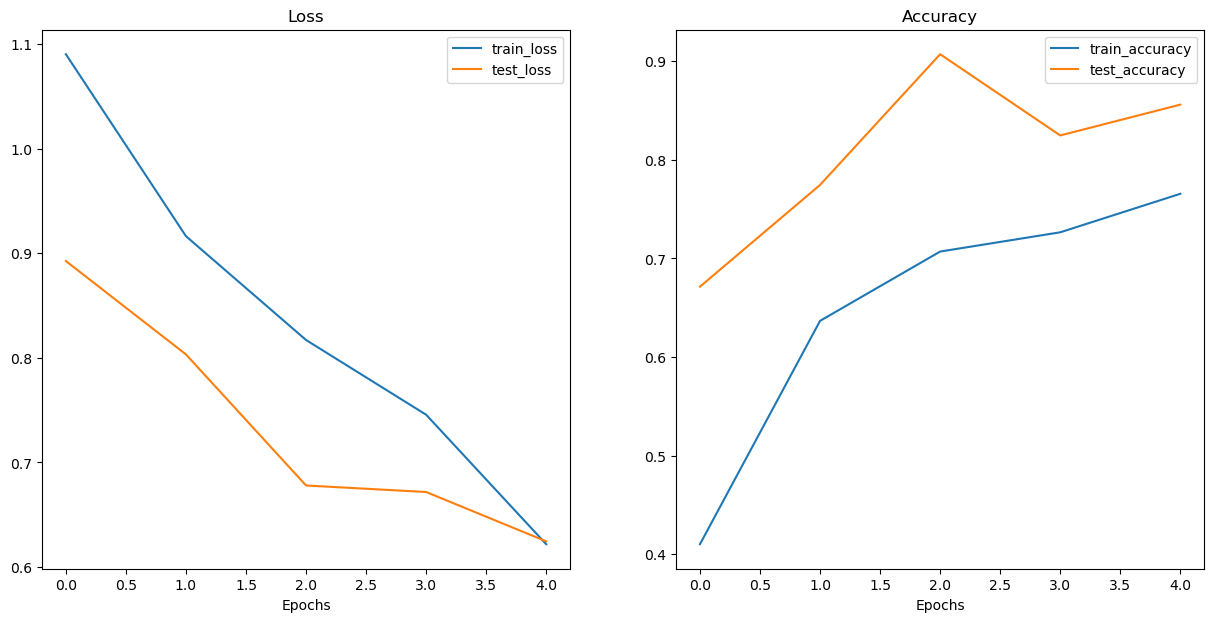

In [45]:
plot_loss_curves(results)

In [58]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device= device):
    img = Image.open(image_path)
    
    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_img = img_transform(img).unsqueeze(0)
        output = model(transformed_img.to(device))
    
    output_pred_prob = torch.softmax(output, dim=1)
    output_pred_label = torch.argmax(output_pred_prob, dim=1)
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[output_pred_label]} | Prob: {output_pred_prob.max():.3f}")
    plt.axis(False)
    

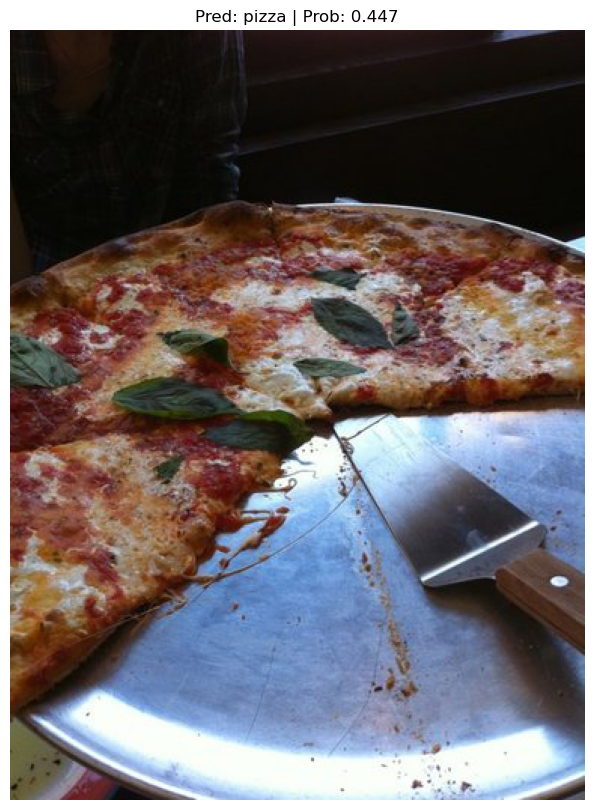

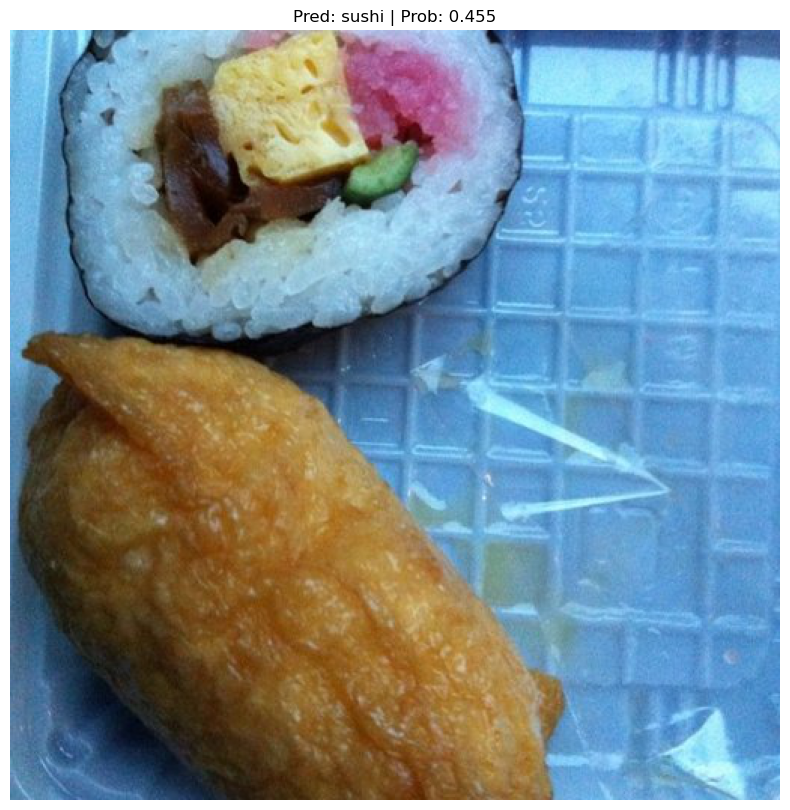

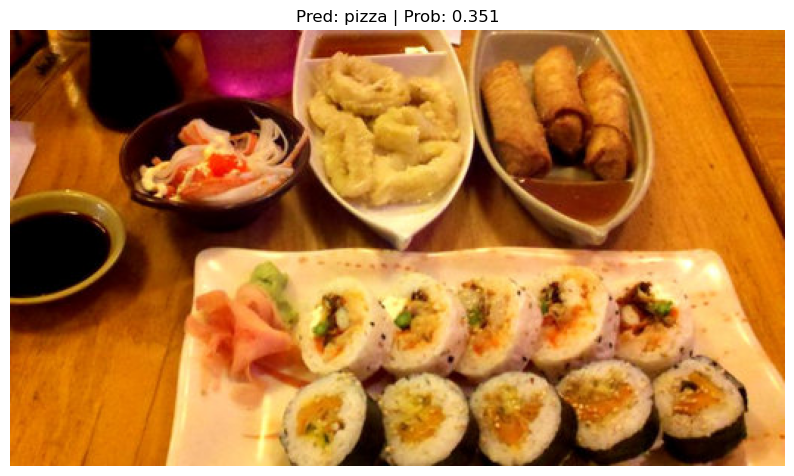

In [59]:
from pathlib import Path
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names)